# TP 2 : Linear regression

Imports for the whole program

In [32]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from scipy.stats import t
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

---

## 1) Data preprocessing

### a) Setting random seeds to 0

In [33]:
np.random.seed(0)
random.seed(0)

### b) Loading the data

In [34]:
df = pd.read_csv('meatspec.csv')  # Load dataset
# Print mean and standard deviation for fat and each covariates
df.describe().loc[['mean', 'std']]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
mean,2.808561,2.811137,2.813727,2.816363,2.819098,2.821983,2.825064,2.828375,2.831943,2.835813,...,3.178262,3.158254,3.138534,3.119104,3.099971,3.08107,3.062290,3.043548,3.024895,18.142326
std,0.410793,0.413352,0.415906,0.418465,0.421040,0.423635,0.426245,0.428866,0.431510,0.434195,...,0.541957,0.541776,0.541519,0.541135,0.540563,0.53973,0.538586,0.537108,0.535354,12.740297


In [35]:
# Extract X matrix and y vector from dataframe and convert it to numpy array
X = df.iloc[:, 0:-1].to_numpy()  # observations
y = df['fat'].to_numpy()

# Store the dimensions of X for the rest of the program
n, p = X.shape

### c) Separating data in train and test sets

In [36]:
# Divide dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)


# Standardize training and test sets
# For X and y the scaler is fitted on the training set
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

### d) Necessity of the intercept

In [37]:
reg = LinearRegression().fit(X_train, y_train)
print(
    f'Value of intercept : {np.round(reg.intercept_[0], 12)}')

Value of intercept : 5e-12


We notice that $intercept \simeq 0$. It's normal because we have standardized the data. So `X_train` and `y_train` are centered by definition.

### e) Creation of `df_coef`

In [38]:
# Dataframe is initialialized with the first R2 value
R2_array = np.array([[reg.score(X_test, y_test)]])

column_values = ['R2']
# First element of the dataframe
index_value = ['sklearn LinearRegression (test)']

df_coef = pd.DataFrame(data=R2_array, index=index_value,
                       columns=column_values).round(3)

df_coef.round(3)

,R2
sklearn LinearRegression,0.96


## 2) Forward variable selection

For the Forward Variable Selection we use the floowing formulas : 

Noise estimation :

$$\hat{\sigma}_n^2(Y, \tilde{X}_k)=\frac{1}{n-2} ||Y-X_k \hat{\theta}_n(Y, \tilde{X}_k)||^2$$
<br><br><br>
Statistical test :

$$\hat{T}_n(Y, \tilde{X}_k) = \sqrt{n} \frac{\left|\tilde{\theta}_n(Y, \tilde{X}_k)\right|}{\hat{\sigma}_n(Y, \tilde{X}_k)}$$
<br><br><br>
p-value :

$$p-value = 2(1-\Phi(\hat{T}_{n,k}))$$

where $\Phi$ is the cumulative distribution of $\mathcal{N}(0,1)$
<br><br><br>
$Y$ update : 

$$Y_i = Y_i - X_{k^*}\hat{\theta}_n(Y, X_k)$$

Where $X_{k^*}$ denotes the feature with the lowest p-value at iteration $k^*$

In [39]:
def forward_variable_selection(X, y, verbose=False):

    n, p = X.shape  # Shape of the matrix

    unselected_features = list(range(0, p))
    sorted_features = []

    p_values = []
    y_temp = y.copy().ravel()  # Flatten y

    for i in range(p):
        p_values = []

        # Iterate through all unselected features to find the one with smallest p-value
        for k in unselected_features:
            X_temp = X[:, k]  # Select column with index k
            X_mean = np.mean(X_temp)
            y_mean = np.mean(y_temp)

            centered_X = X_temp - X_mean
            centered_y = y_temp - y_mean

            reg = LinearRegression().fit(centered_X.reshape(-1, 1), centered_y)

            theta = (centered_X * centered_y).sum() / \
                (centered_X**2).sum()

            sigma = np.linalg.norm(centered_y - theta * centered_X)**2 / (n-2)

            T = np.sqrt(n) * abs(theta) / sigma**0.5  # Statistical test

            p_value = 2 * (1 - norm.cdf(T))

            p_values.append([k, p_value, centered_X, theta])

        min_feature_idx, min_p_value, x_min, theta = min(
            p_values, key=lambda x: x[1])  # Select feature with smallest p-value

        if verbose:
            print(
                f'Selected p-value : {round(min_p_value, 2)}, index : {min_feature_idx}')

        y_temp = y_temp - theta * x_min  # Update y value

        sorted_features.append([min_feature_idx, round(min_p_value, 2)])
        unselected_features.remove(min_feature_idx)

    return sorted_features

### 3) Testing the algorithm

In [40]:
# We run the Forward Variables Selection on the training set
sorted_values = forward_variable_selection(X_train, y_train, verbose=False)

# We select the features with a p-value smaller than 0.05
selected = [feature for feature in sorted_values if feature[1] <= 0.05]
# Get the indices of the selected features
indices = np.array(selected)[:, 0].astype('int')
print(f'{len(selected)} features selected')

# We extract the features according the indices
X_train_selected = X_train[:, indices]
X_test_selected = X_test[:, indices]

5 features selected


### a) Applying the OLS of the `sklearn` library

In [41]:
reg = LinearRegression(fit_intercept=False).fit(X_train_selected, y_train)

# R2 for forward feature selection
R2_ffs = reg.score(X_test_selected, y_test)

print(f'R2 for Forward Variable Selection : {R2_ffs}')
df_coef.loc['Forward Variable Selection (test)'] = [R2_ffs]
df_coef.round(3)

R2 for Forward Variable Selection : 0.8848433811774775


,R2
sklearn LinearRegression,0.960
Forward Variable Selection (test),0.885


## 4) Selecting number of variables

In [42]:
# Regression to compare with the result of the function forward_variable_selection above
reg_comp = LinearRegression()
selector = sfs(reg_comp, forward=True, k_features='best', verbose=0, n_jobs=-1)
selector = selector.fit(X_train, y_train)

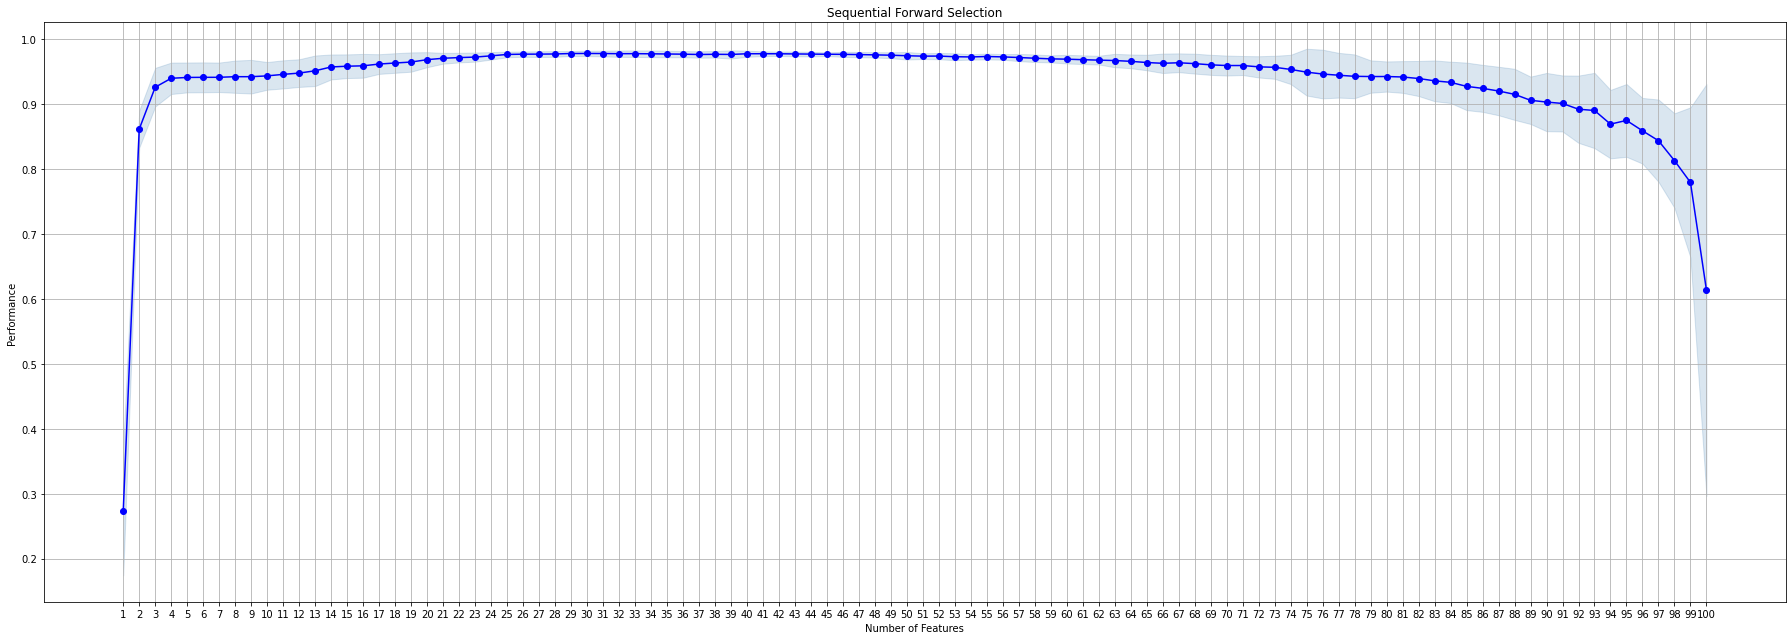

Number of selected features : 30


In [43]:
selected_train_features = selector.transform(X_train)
selected_test_features = selector.transform(X_test)

fig = plot_sfs(selector.get_metric_dict(), figsize=(25, 9))
plt.title('Sequential Forward Selection')
plt.grid()
plt.tight_layout()
plt.show()

print(f'Number of selected features : {len(selected_train_features[0])}')

In [44]:
reg_comp.fit(selected_train_features, y_train)
score = reg_comp.score(selected_test_features, y_test)
print(f'R2 for Sequential Feature Selection : {np.round(score, 3)}')
df_coef.loc['Sequential Forward Selection'] = [score]

df_coef.round(3)

R2 for Sequential Feature Selection : 0.945


,R2
sklearn LinearRegression,0.960
Forward Variable Selection (test),0.885
Sequential Forward Selection,0.945


Sequential feature selection is more accurate than forward feature selection as it evaluates the performance on multiple subsets of features and selects the best one.

(& test on multiple subsets at the same time vs test on one subset at a time)

### 5) Ridge

In [45]:
# Fit function for ridge estimator
def ridge_estimator_fit(X, y, alpha=0.01):
    n, p = X.shape
    return np.array(np.linalg.inv(X.T.dot(X) + n*alpha*np.eye(p)).dot(X.T).dot(y))


# Estimator function for ridge
def ridge_estimator_predict(X, alpha):
    return X.dot(alpha.reshape(-1, 1))

### a) Values of the coefficients change with $\alpha$

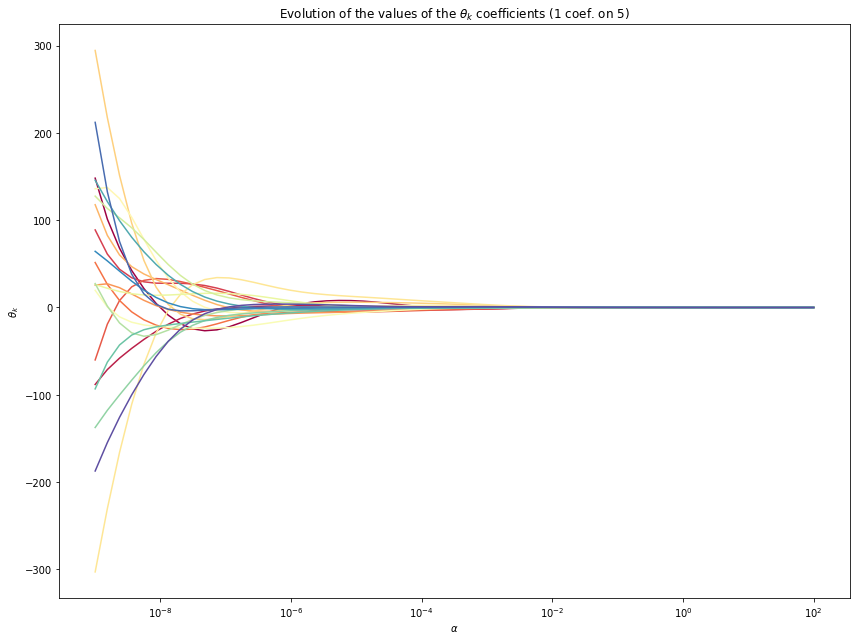

In [46]:
# Makes X scale invariant
def normalized_set(X):
    n, p = X.shape
    Ip = np.eye(p)
    D = np.zeros((p, p))

    for i in range(p):
        D[i][i] = np.linalg.norm(X @ Ip[:, i])
    return X @ np.linalg.inv(D)
    # return X/np.sqrt(n)


# Normalize X_train according to the lecture notes
X_train_normalized = normalized_set(X_train)
# Normalize X_test according to the lecture notes
X_test_normalized = normalized_set(X_test)

alphas = np.logspace(-9, 2, 60)
# coefs = np.array([ridge_estimator_fit(X_train, y_train, alpha=alpha) for alpha in alphas])
coefs = np.array([ridge_estimator_fit(X_train_normalized,
                 y_train, alpha=alpha) for alpha in alphas])


plt.figure(figsize=(12, 9))
ax = plt.gca()
ax.set_prop_cycle('color', plt.cm.Spectral(np.linspace(0, 1, 20)))

# plot only 20 of the 100 coefficients
for i in range(20):
    ax.plot(alphas, coefs[:, 5*i])
ax.set_xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\theta_k$')
plt.title(r'Evolution of the values of the $\theta_k$ coefficients (1 coef. on 5)')
plt.tight_layout()
plt.show()

We observe that : $\forall k \in (1,...,p), \lim\limits_{\alpha \rightarrow +\infty} \theta_k = 0$

### b) MSE of train and test sets change with $\alpha$

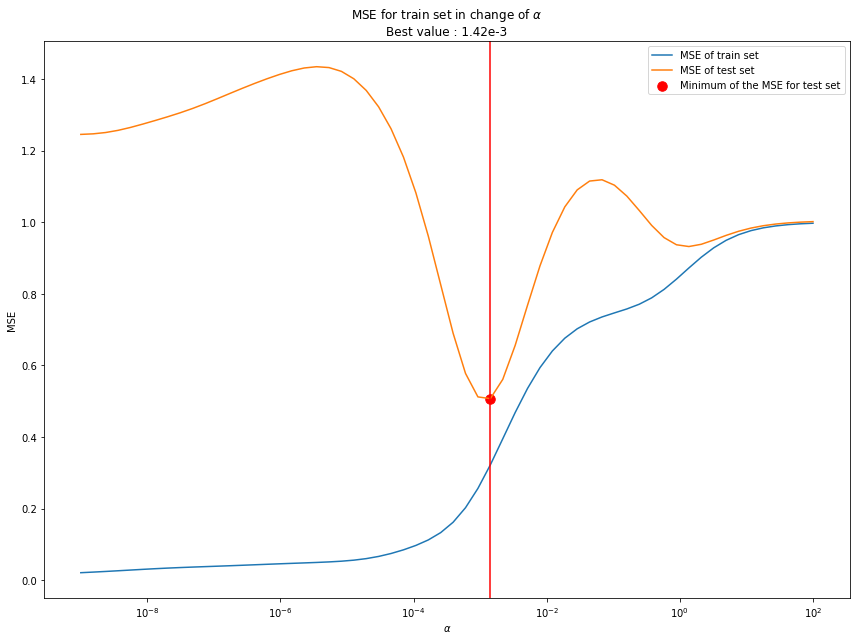

In [47]:
# MSE for train set
y_train_preds = [ridge_estimator_predict(
    X_train_normalized, coefs[i, :]) for i in range(len(alphas))]
mse_train = [mean_squared_error(y_train, y_train_preds[i])
             for i in range(len(y_train_preds))]

# MSE for test set
y_test_preds = [ridge_estimator_predict(
    X_test_normalized, coefs[i, :]) for i in range(len(alphas))]
mse_test = [mean_squared_error(y_test, y_test_preds[i])
            for i in range(len(y_test_preds))]

# Find the minimum of mse_test
min_index = np.argmin(np.array(mse_test))
mse_min = mse_test[min_index]
alpha_min = alphas[min_index]

plt.figure(figsize=(12, 9))
ax = plt.gca()
title = r'MSE for train set in change of $\alpha$' + \
    f'\nBest value : {np.format_float_scientific(alpha_min, precision=2, exp_digits=1)}'
plt.title(title)
plt.plot(alphas, mse_train, label='MSE of train set')
plt.plot(alphas, mse_test, label='MSE of test set')
plt.scatter(alpha_min, mse_min, c='red', s=90,
            label='Minimum of the MSE for test set')
plt.axvline(alpha_min, c='red')
plt.legend()
ax.set_xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.tight_layout()
plt.show()

### c) R2 on the test set for best $\alpha$

In [48]:
# R2 calculated with the formula given in the lecture notes
R2_ridge = 1-np.linalg.norm(y_test_preds[min_index] -
                            y_test)**2/np.linalg.norm(y_test - np.mean(y_test))**2

print(f'R2 for Ridge : {round(R2_ridge, 3)}')
df_coef.loc['Ridge estimator (test)'] = [R2_ridge]
df_coef.round(3)

R2 for Ridge : 0.495


,R2
sklearn LinearRegression,0.960
Forward Variable Selection (test),0.885
Sequential Forward Selection,0.945
Ridge estimator (test),0.495


## 6) Lasso

### a) `tol` and `maxiter` parameters

In [49]:
# Parameters that seem to provide the best results
lasso_length = 50
lasso_max_iters = 10_000
lasso_tol = 0.02

alpha_lasso = np.logspace(-5, -2, lasso_length)

lasso_fit = []  # List containaining the ceofficients of the estimator

lasso_train_predictions = []  # List containing train predictions
lasso_test_predictions = []  # List containing test predictions

lasso_train_errors = []  # List containing train errors
lasso_test_errors = []  # List containing test errors

lassos = []

# We compute the Lasso estimator for each value of alpha
for alpha in alpha_lasso:
    lasso = Lasso(alpha=alpha, tol=lasso_tol, max_iter=lasso_max_iters)
    lasso_fit.append(lasso.fit(X_train_normalized, y_train))
    lassos.append(lasso)

    # Predicitons
    train_predictions = lasso.predict(X_train_normalized)
    test_predictions = lasso.predict(X_test_normalized)

    lasso_train_predictions.append(train_predictions)
    lasso_test_predictions.append(test_predictions)

    # Errors computation
    lasso_train_errors.append(mean_squared_error(y_train, train_predictions))
    lasso_test_errors.append(mean_squared_error(y_test, test_predictions))

There is no explicit expression of the Lasso estimator because of the lack of smoothness of $||.||_1$. <br>
So the Lasso of `sklearn` uses a gradient descent to approximate the estimator.<br>
But in some cases, the descent may not converge in the default number of iterations (1000 according to the `sklearn` documentation).<br>
The solutions are to increase the tolerance or the number of iterations.

### b) Coefficients different from 0 for each value of $\alpha$

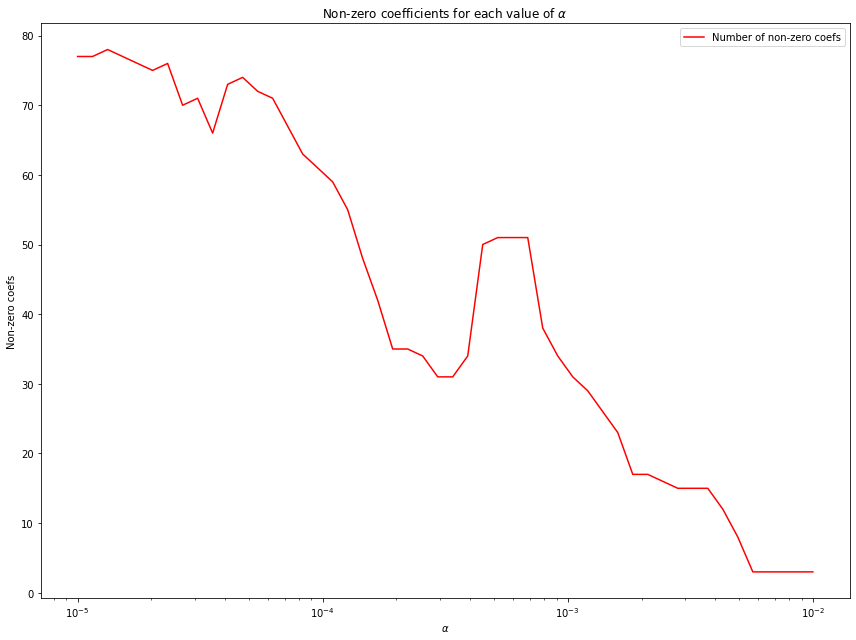

In [50]:
# We store the number of non-zero coefficients for each value of alpha
non_zeros = [len([x for x in lasso_fit[i].coef_ if x != 0])
             for i in range(lasso_length)]

plt.figure(figsize=(12, 9))
plt.title(r'Non-zero coefficients for each value of $\alpha$')
plt.semilogx(alpha_lasso, non_zeros, c='red', label='Number of non-zero coefs')
plt.xlabel(r'$\alpha$')
plt.ylabel(f'Non-zero coefs')
plt.legend()
plt.tight_layout()
plt.show()

The number of non-zeros coefficients is decreases when $\alpha$ increases. For a value of $\alpha$ around $10^{-2}$, all the coefficients are zeros.

### c) MSE for train and test sets

As mentioned in the lecture notes, I use the scale-invariant versions of <code>X_train</code> and <code>X_test</code>.

#### Plot the results for LASSO

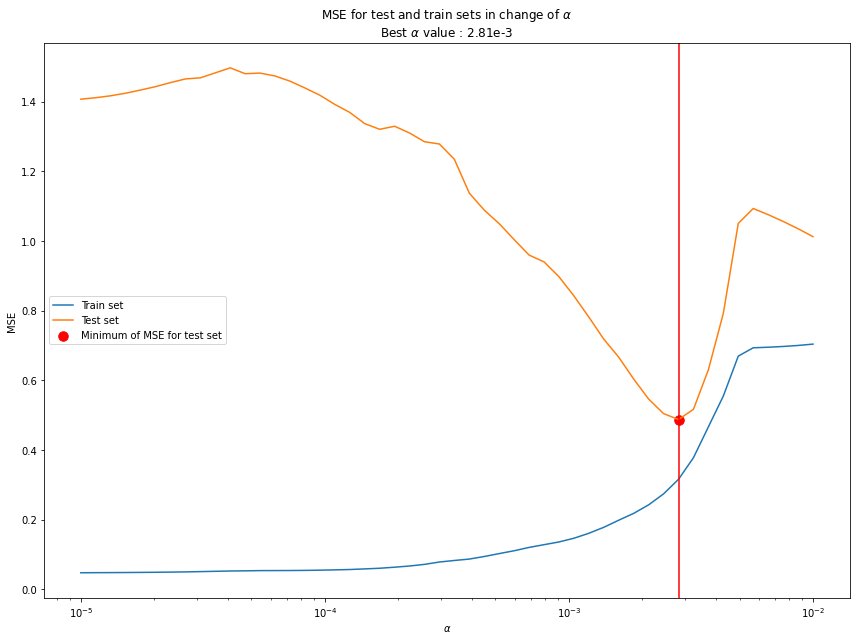

In [51]:
# Find the minimum of test_errors
min_index_lasso = np.argmin(np.array(lasso_test_errors))
mse_lasso_min = lasso_test_errors[min_index_lasso]
alpha_lasso_min = alpha_lasso[min_index_lasso]


plt.figure(figsize=(12, 9))
plt.title(
    r'MSE for test and train sets in change of $\alpha$' + '\n' + r'Best $\alpha$ value : ' + np.format_float_scientific(alpha_lasso_min, precision=2, exp_digits=1))
# logarithmic scale
plt.semilogx(alpha_lasso, lasso_train_errors, label='Train set')
plt.semilogx(alpha_lasso, lasso_test_errors, label='Test set')
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.scatter(alpha_lasso_min, mse_lasso_min, c='red',
            s=90, label='Minimum of MSE for test set')
plt.axvline(alpha_lasso_min, c='red')
plt.legend()
plt.tight_layout()
plt.show()

### d) R2 for the best value of $\alpha$

In [78]:
R2_lasso = lassos[min_index_lasso].score(X_test_normalized, y_test)
print(f'R2 for Lasso : {round(R2_lasso, 3)}')
df_coef.loc['Lasso estimator (test)'] = [R2_lasso]
df_coef.round(3)

R2 for Lasso : 0.515


,R2
sklearn LinearRegression,0.960
Forward Variable Selection (test),0.885
Sequential Forward Selection,0.945
Ridge estimator (test),0.495
Lasso estimator (test),0.515
Elastic net (test),0.854
PCA (test),0.905


## 7) Crossvalidation

In [53]:
def crossvalidation(X, y, k_folds, alphas, estimator):

    # We use KFold from sklearn to split the dataset into k folds
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
    r = len(alphas)
    errors = np.zeros((k_folds, len(alphas)))

    current_fold = 0

    for train_index, test_index in kf.split(X):

        # Separate data into training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        temp_errors = []

        if estimator == 'lasso':

            for alpha in alphas:
                lasso = Lasso(alpha=alpha, tol=0.1, max_iter=50_000)
                fit = lasso.fit(X_train, y_train)
                y_pred = lasso.predict(X_test)
                error = mean_squared_error(y_test, y_pred)
                temp_errors.append(error)

        elif estimator == 'ridge':

            for alpha in alphas:
                fit = ridge_estimator_fit(X_train, y_train, alpha=alpha)
                y_pred = ridge_estimator_predict(X_test, fit)
                error = mean_squared_error(y_test, y_pred)
                temp_errors.append(error)

        errors[current_fold, :] = temp_errors

        current_fold += 1

    # Calucate the average error for each colum of error matrix
    avg_errors = np.mean(errors, axis=0)
    min_error = np.argmin(avg_errors)
    alpha_min = alphas[min_error]

    return alpha_min, avg_errors


lasso_reg, lasso_err = crossvalidation(X_train_normalized, y_train, 5, [
                                       0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99], 'lasso')
ridge_reg, ridge_err = crossvalidation(
    X_train_normalized, y_train, 5, np.logspace(-10, 3, 15), 'ridge')

#### Test with `ElasticNet` from sklearn

The `ElasticNet` function from `sklearn` requires 2 arguments defined as follows : 

$$\alpha = a + b$$
$$l_1 = \frac{a}{a+b}$$

where $a$ and $b$ are the regularization penalty coefficients for Ridge and Lasso estimators. 

In [54]:
# Parameter for elastic net
alpha_elastic_net = lasso_reg + X_train.shape[0] * ridge_reg
l1_elastic_net = lasso_reg / (lasso_reg + X_train.shape[0] * ridge_reg)

elastic_net = ElasticNet(alpha=alpha_elastic_net,
                         l1_ratio=l1_elastic_net, random_state=0).fit(X_train, y_train)
R2_elastic_net = elastic_net.score(X_test, y_test)

print(f'')
df_coef.loc['Elastic net (test)'] = R2_elastic_net
df_coef.round(3)

,R2
sklearn LinearRegression,0.960
Forward Variable Selection (test),0.885
Sequential Forward Selection,0.945
Ridge estimator (test),0.495
Lasso estimator (test),0.515
Elastic net (test),0.854


## 8) Bootstrap

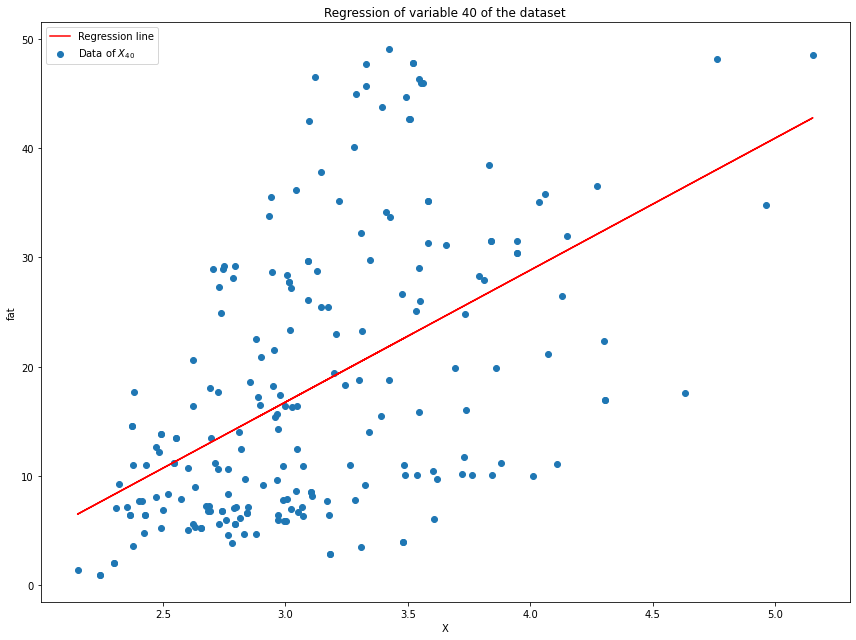

In [55]:
X_40 = X[:, 39]
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_40.reshape(-1, 1), y)

plt.figure(figsize=(12, 9))
plt.title('Regression of variable 40 of the dataset')
plt.plot(X_40, lin_reg.coef_[0]*X_40 +
         lin_reg.intercept_, c='red', label='Regression line')
plt.scatter(X_40, y, label=r'Data of $X_{40}$')
plt.xlabel('X')
plt.ylabel('fat')
plt.legend()
plt.tight_layout()
plt.show()

To plot the prediciton intervals for each sample, we need first to compute the lower and upper bounds. We start from the result given in the exercise 5 of the lecture notes :

$$\frac{Y - (\hat{\beta}_0 + \hat{\beta}_1 x)}{\hat{\sigma}\sqrt{1+\frac{1}{n} + \frac{(x-\bar{x}^n)^2}{\sum_{i=1}^n (x_i-\bar{x}^n)^2} }} \sim t(n-2)$$
<br><br><br>
Where $$\hat{\sigma}^2=\frac{1}{n-2}\sum_{i=1}^n(Y_i-(\hat{\beta}_0 + \hat{\beta}_1 x))^2$$

If we denote by $t_{1-\frac{\alpha}{2}}$ the quantile of order $1-\frac{\alpha}{2}$ of the Student's distribution with $n-2$ degrees of freedom, the prediction interval is :
<br><br><br><br>

$$Y \in \left[\hat{\beta}_0 + \hat{\beta}_1 x - t_{1-\frac{\alpha}{2}}\hat{\sigma}\sqrt{1+\frac{1}{n} + \frac{(x-\bar{x}^n)^2}{\sum_{i=1}^n (x_i-\bar{x}^n)^2}}\hspace{5pt} , \hspace{5pt} \hat{\beta}_0 + \hat{\beta}_1 x + t_{1-\frac{\alpha}{2}}\hat{\sigma}\sqrt{1+\frac{1}{n} + \frac{(x-\bar{x}^n)^2}{\sum_{i=1}^n (x_i-\bar{x}^n)^2}} \hspace{3pt}\right]$$

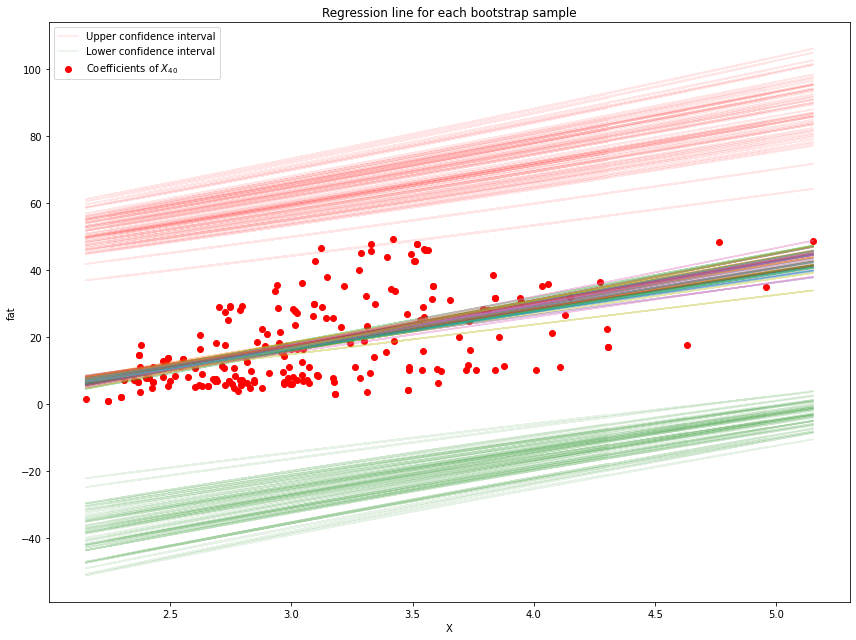

In [76]:
bootstrap_samples = 50  # Number of bootstrap samples
coefs = []  # List of the coefficients of the OLS
intercepts = []  # List of the intercept of the OLS
intervals = []

alpha = 0.05  # Set a 5% confidence interval

reg_bootstrap = LinearRegression(fit_intercept=True)

plt.figure(figsize=(12, 9))
plt.title('Regression line for each bootstrap sample')
plt.xlabel('X')
plt.ylabel('fat')


for i in range(bootstrap_samples):
    X_sample, y_sample = resample(
        X_40, y, n_samples=len(X_40), random_state=i, replace=True)

    X_sample_mean = np.mean(X_sample)
    y_sample_mean = np.mean(y_sample)

    reg_bootstrap.fit(X_sample.reshape(-1, 1), y_sample)
    coef = reg_bootstrap.coef_
    intercept = reg_bootstrap.intercept_

    # We use the formulas provided by the lecture notes
    sigma = 1/(n-2)*((y_sample - coef * X_sample)**2).sum()
    temp = np.sqrt(sigma * (1 + n**-1 + (X_40 - X_sample_mean)**2 /
                   ((X_sample - X_sample_mean)**2).sum())) * t.ppf(1-0.5*alpha, n-2)

    # Lower and upper bounds of the confidence interval
    lower = intercept + coef * X_40 - temp
    upper = intercept + coef * X_40 + temp

    coefs.append(coef)
    intercepts.append(intercept)

    plt.plot(X_40.reshape(-1, 1),
             reg_bootstrap.coef_[0] * X_40 + reg_bootstrap.intercept_, alpha=.4)
    plt.plot(X_40.reshape(-1, 1), upper, alpha=.1, c='red',
             label=('Upper confidence interval' if i == 0 else ''))
    plt.plot(X_40.reshape(-1, 1), lower, alpha=.1, c='green',
             label=('Lower confidence interval' if i == 0 else ''))


plt.scatter(X_40, y, label=r'Coefficients of $X_{40}$', c='red')

plt.legend()
plt.tight_layout()
plt.show()

## 9) PCA

### a) Heatmap of the covariance matrix

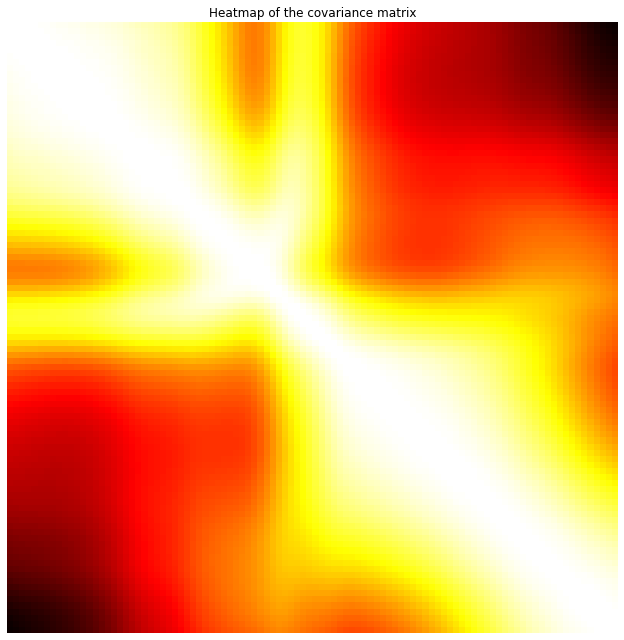

In [57]:
X_mean = np.mean(X_train, axis=0)

# X_centered is not exactly scale invariant but there is no major difference between the two versions
X_centered = X_train - X_mean

cov_mat = np.cov(X_centered.T)

plt.figure(figsize=(9, 9))
plt.title('Heatmap of the covariance matrix')
plt.imshow(cov_mat, cmap='hot')
plt.axis('off')
plt.tight_layout()
plt.show()

### b) PCA

In [58]:
def PCA(X, k):
    # Center X
    X_centered = X - np.mean(X)

    # Compute covariance matrix of features
    cov_mat = np.cov(X_centered.T)

    # SVD
    U, s, V = np.linalg.svd(cov_mat)

    # Select eigenvectors according to the degree k (they are already sorted)
    eigen_vectors_subset = U[:, :k]

    X_reduced = np.dot(eigen_vectors_subset.T, X_centered.T).T

    return X_reduced

### c) Plotting the variance

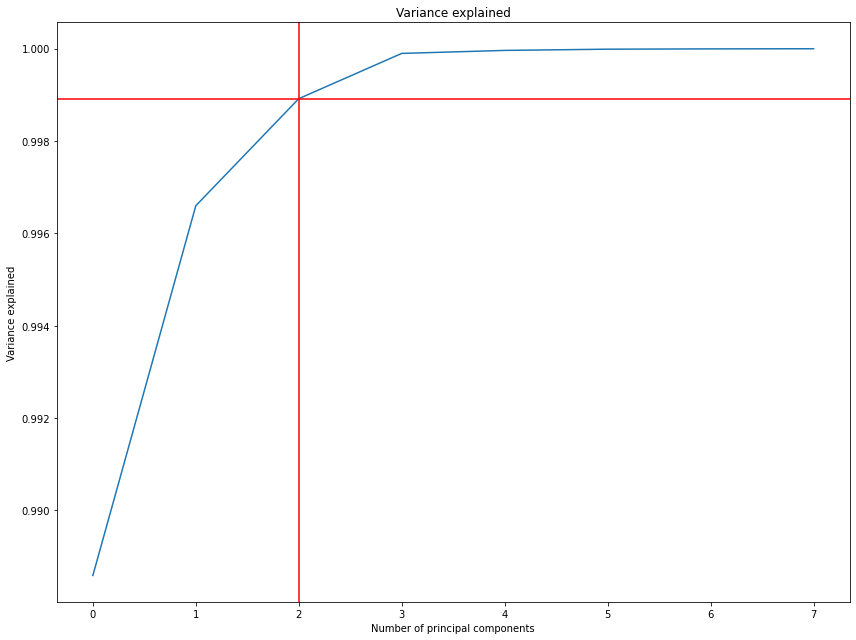

In [75]:
# Compute SVD
U_train, s_train, V_train = np.linalg.svd(normalized_set(X_train))

var_explained = np.cumsum(s_train**2) / np.sum(s_train**2)

plt.figure(figsize=(12, 9))
plt.plot(var_explained[:8])
plt.title('Variance explained')
plt.xlabel('Number of principal components')
plt.ylabel('Variance explained')
plt.axvline(2, c='red')
plt.axhline(var_explained[2], c='red')
plt.tight_layout()
plt.show()

As we can see, using the two first principal components is enough to explain more than 99,8% of the total variance.

### d) Testing PCA function with $k=2$

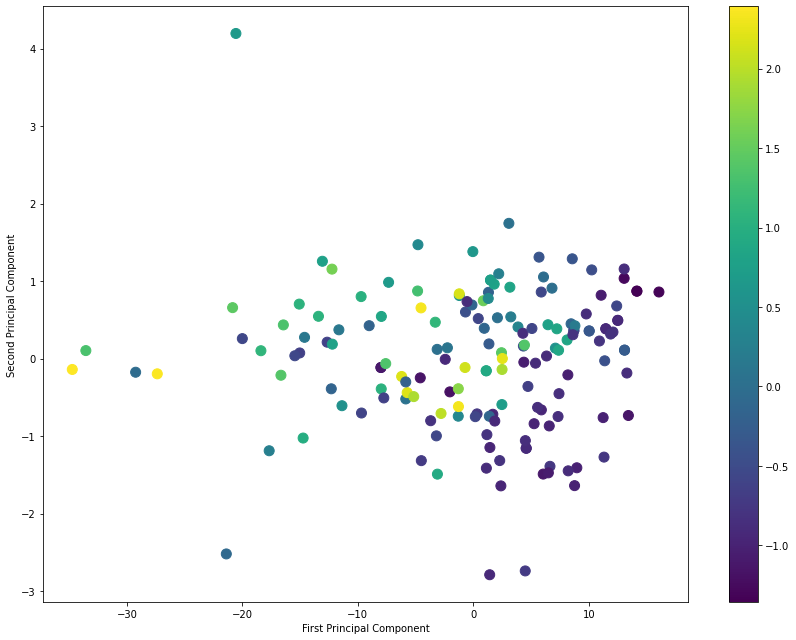

In [60]:
# Compute PCA for 2 components
X_reduced = PCA(X_train, 2)

plt.figure(figsize=(12, 9))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, s=100)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.tight_layout()
plt.show()

We notice that the lowest values of $y_{train}$ are clustered on the right of the plot (navy blue points). One can consider that the two first components are enough to explain the data distribution.<br>
However, there seem to be outliners (extremal value on the plot)

### e) OLS on the projected data

In [61]:
indices = np.linspace(2, p-1, 10).astype('int')
pca_scores = []

# We apply PCA for 10 different values of k
for k in indices:
    X_reduced = PCA(X_train, k)
    reg_pca = LinearRegression(fit_intercept=True).fit(X_reduced, y_train)

    X_test_reduced = PCA(X_test, k)
    pca_scores.append(reg_pca.score(X_test_reduced, y_test))

# Get the maximum score among all the calculated scores
max_score_index = np.argmax(pca_scores)
R2_pca = pca_scores[max_score_index]

print(f'Max R2 for k = {indices[max_score_index]}, Value : {R2_pca}')
df_coef.loc['PCA (test)'] = R2_pca
df_coef.round(3)

Max R2 for k = 12, Value : 0.9051609680099337


,R2
sklearn LinearRegression,0.960
Forward Variable Selection (test),0.885
Sequential Forward Selection,0.945
Ridge estimator (test),0.495
Lasso estimator (test),0.515
Elastic net (test),0.854
PCA (test),0.905


## 10) Comparing results

Among all the R2 values, linear regression seem to be the most accurate method.

It is normal that ``Forward`` and ``Sequential Variable Selection`` are less accurate the ``OLS``. Indeed, the procedures use an OLS at the end but with less features.<br>
These two methods would have been more efficient with a larger number of features because many of them would be useless.<br>
However, it's normal for ``Sequantiel Variable Selection`` to be more accurate than ``Forward Variable Selection``. Indeed we iteratively look for the best R2 among all the features combinations. But it requires a larger amount of computations.

Event though ``Ridge`` and ``Lasso`` are designed to avoid overfitting on training set, it should be expected R2 values on test set to be at least as good as than regular ``OLS``. For ``Ridge`` estimator, this bad result is probably linked to a bad implementation but I didn't achieve to find the error if their is one.<br>
The result is more annoying for ``Lasso`` estimator because it is the one implemented in sklearn so it should work. A possible explanation is that regularization term is to high. In this case, both estimators are not able to even fit the train set.

For ``Elastic Net``, it is normal to get a higher R2 score than ``Ridge`` and ``Lasso``. It is a combination of these two estimators. However, when looking at the values of the regularization parameters chosen above, we notice that they are almost zero. It means that my version of ``Elastic Net`` is extremely near to the ``OLS``. So we can conclude that ``Elastic Net`` estimator is less fitted to training data but more efficient than ``Ridge`` and ``Lasso`` to test set.

We can conclude that the number of covariates is small enough to use ``OLS`` without overfitting. Hence the only improvement we could provide is reducing the number of covariates with ``Sequential Variable Selection`` in order to reduce computation time.